<a href="https://colab.research.google.com/github/akashsiddharth1/BrainTumor_classification/blob/main/Brain_Tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BRAIN TUMOR CLASSIFICATION

In [3]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 133.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 107.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [tensorflow]


In [2]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Understand the Dataset


Review the number of categories (tumor types) and sample images.


Check for class imbalance and image resolution consistency.


Explore image distributions visually. **bold text**


In [2]:
data_dir = "/content/drive/MyDrive/Files/Tumour"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

classes = ['glioma', 'meningioma', 'pituitary', 'no_tumor']

In [3]:
# Check image counts per class
train_counts = {}
val_counts = {}
test_counts = {}
for cls in classes:
    train_counts[cls] = len(os.listdir(os.path.join(train_dir, cls)))
    val_counts[cls] = len(os.listdir(os.path.join(val_dir, cls)))
    test_counts[cls] = len(os.listdir(os.path.join(test_dir, cls)))
    print(f"{cls}: Train={train_counts[cls]}, Val={val_counts[cls]}, Test={test_counts[cls]}")

glioma: Train=564, Val=161, Test=80
meningioma: Train=358, Val=124, Test=63
pituitary: Train=438, Val=118, Test=54
no_tumor: Train=335, Val=99, Test=49


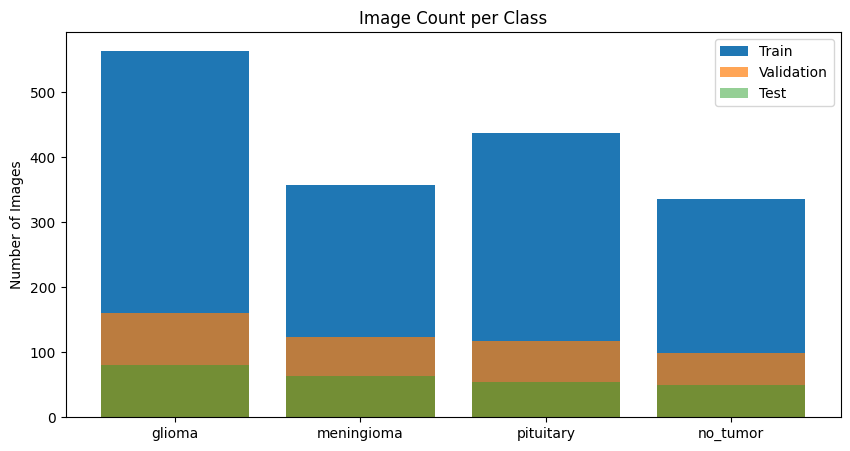

In [4]:
# Visualize class distribution
plt.figure(figsize=(10, 5))
plt.bar(train_counts.keys(), train_counts.values(), label='Train')
plt.bar(val_counts.keys(), val_counts.values(), label='Validation', alpha=0.7)
plt.bar(test_counts.keys(), test_counts.values(), label='Test', alpha=0.5)
plt.title("Image Count per Class")
plt.ylabel("Number of Images")
plt.legend()
plt.show()

In [5]:
# Check image resolution consistency
img_shapes = defaultdict(int)
for cls in classes:
    sample_dir = os.path.join(train_dir, cls)
    for img_name in os.listdir(sample_dir)[:50]:  # Sample 50 images
        img_path = os.path.join(sample_dir, img_name)
        try:
            img = Image.open(img_path)
            img_shapes[img.size] += 1
        except:
            continue

print("\nImage Resolution Distribution (from 50 samples per class):")
for shape, count in img_shapes.items():
    print(f"{shape}: {count} images")


Image Resolution Distribution (from 50 samples per class):
(640, 640): 200 images


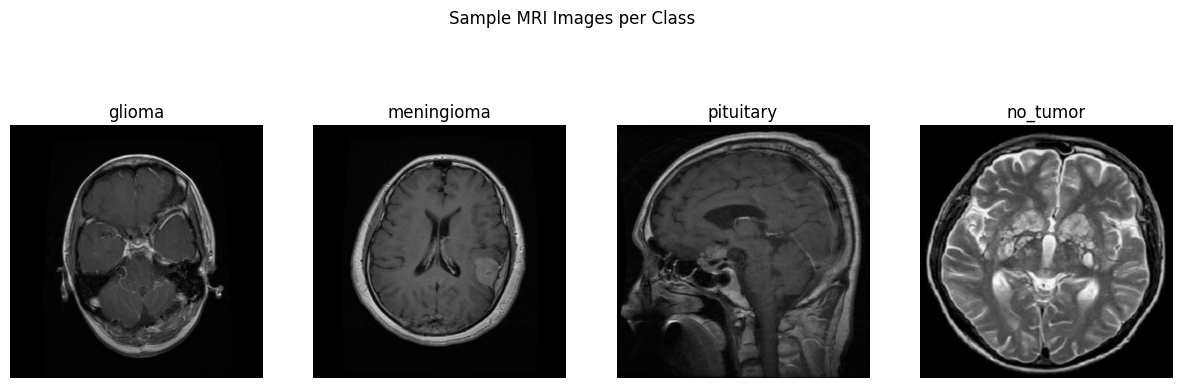

In [6]:
# Visualize sample images per class
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, cls in enumerate(classes):
    sample_img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = Image.open(sample_img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.suptitle("Sample MRI Images per Class")
plt.show()

# Data Preprocessing


Normalize pixel values to a 0–1 range.


Resize images to a consistent shape suitable for model input (e.g. 224x224 pixels).


In [20]:
img_size = (224, 224)
batch_size = 64

# Normalize pixel values (0–1 range)
preprocess_datagen = ImageDataGenerator(rescale=1./255)

# Preprocessing for training, validation, and test sets
train_preproc = preprocess_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_preproc = preprocess_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_preproc = preprocess_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


# Data Augmentation


Apply transformations like rotation, horizontal/vertical flipping, zoom, brightness adjustments, and shifts to artificially increase training data and improve model generalization.


In [21]:
#Data Augmentation
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = augment_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = preprocess_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = preprocess_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [9]:
for cls, count in train_generator.class_indices.items():
    print(f"{cls}: {count}")


glioma: 0
meningioma: 1
no_tumor: 2
pituitary: 3


In [10]:
# Get class distribution
labels_count = train_generator.classes
unique, counts = np.unique(labels_count, return_counts=True)
print(dict(zip(train_generator.class_indices.keys(), counts)))


{'glioma': np.int64(564), 'meningioma': np.int64(358), 'no_tumor': np.int64(335), 'pituitary': np.int64(438)}


In [22]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_count),
    y=labels_count
)
class_weights = dict(enumerate(class_weights))


# Model Building


Custom CNN: Design a convolutional neural network from scratch, selecting appropriate convolution, pooling, and dense layers.


Implement dropout and batch normalization layers to avoid overfitting and stabilize learning.


In [23]:
# Build custom CNN using explicit Input layer
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.5),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
custom_cnn = build_custom_cnn()

# Transfer Learning


Load pretrained models (Example : ResNet50, MobileNetV2, InceptionV3, EfficientNetB0) with ImageNet weights.


Replace the top classification layers with new dense layers suited for the tumor categories.


Optionally unfreeze top layers for fine-tuning after initial training.


In [24]:
# Generic function for transfer learning

def build_transfer_model(base_model_class, input_shape=(224, 224, 3), num_classes=4, fine_tune_at=None):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)

    if fine_tune_at:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune_at]:
            layer.trainable = False
    else:
        base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=outputs)

In [26]:
# Instantiate models
resnet_model = build_transfer_model(ResNet50)
mobilenet_model = build_transfer_model(MobileNetV2)
inception_model = build_transfer_model(InceptionV3)
efficientnet_model = build_transfer_model(EfficientNetB0)

# Model Training


Train both custom CNN and transfer learning models.


Use callbacks like EarlyStopping and ModelCheckpoint to monitor validation loss and save the best performing models.


Track training and validation metrics.


In [27]:
# Training Function with Callbacks
def train_model(model, name):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(f"{name}.h5", monitor='val_accuracy', save_best_only=True)
    ]

    history = model.fit(
        train_generator,
        epochs=25,
        validation_data=val_generator,
        callbacks=callbacks,
        class_weight=class_weights

    )
    return history


In [ ]:
# Train all models
custom_history = train_model(custom_cnn, "custom_cnn")
resnet_history = train_model(resnet_model, "resnet50")
mobilenet_history = train_model(mobilenet_model, "mobilenetv2")
inception_history = train_model(inception_model, "inceptionv3")
efficientnet_history = train_model(efficientnet_model, "efficientnetb0")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3143 - loss: 10.6007

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 439s 16s/step - accuracy: 0.3148 - loss: 10.4343 - val_accuracy: 0.4562 - val_loss: 1.3548
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 250s 9s/step - accuracy: 0.4161 - loss: 1.3402 - val_accuracy: 0.3207 - val_loss: 1.3851
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 261s 9s/step - accuracy: 0.3895 - loss: 1.3364 - val_accuracy: 0.3187 - val_loss: 1.3843
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 254s 9s/step - accuracy: 0.3600 - loss: 1.3526 - val_accuracy: 0.3028 - val_loss: 1.3818
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 249s 9s/step - accuracy: 0.3922 - loss: 1.3160 - val_accuracy: 0.3307 - val_loss: 1.3756
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 250s 9s/step - accuracy: 0.3944 - loss: 1.3095 - val_accuracy: 0.2968 - val_loss: 1.3716
Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.2418 - loss: 1.6322 

27/27 ━━━━━━━━━━━━━━━━━━━━ 490s 18s/step - accuracy: 0.2424 - loss: 1.6291 - val_accuracy: 0.3227 - val_loss: 1.3399
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.2918 - loss: 1.4047 

27/27 ━━━━━━━━━━━━━━━━━━━━ 417s 16s/step - accuracy: 0.2921 - loss: 1.4041 - val_accuracy: 0.5060 - val_loss: 1.2550
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3189 - loss: 1.3435 

27/27 ━━━━━━━━━━━━━━━━━━━━ 467s 17s/step - accuracy: 0.3193 - loss: 1.3432 - val_accuracy: 0.5219 - val_loss: 1.2209
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 465s 17s/step - accuracy: 0.3708 - loss: 1.2972 - val_accuracy: 0.3665 - val_loss: 1.2035
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3906 - loss: 1.2710 

27/27 ━━━━━━━━━━━━━━━━━━━━ 467s 18s/step - accuracy: 0.3912 - loss: 1.2705 - val_accuracy: 0.5976 - val_loss: 1.1878
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 411s 15s/step - accuracy: 0.4438 - loss: 1.2305 - val_accuracy: 0.4900 - val_loss: 1.1916
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4101 - loss: 1.2519 

27/27 ━━━━━━━━━━━━━━━━━━━━ 413s 15s/step - accuracy: 0.4115 - loss: 1.2505 - val_accuracy: 0.6315 - val_loss: 1.1353
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4433 - loss: 1.2226 

27/27 ━━━━━━━━━━━━━━━━━━━━ 410s 15s/step - accuracy: 0.4437 - loss: 1.2221 - val_accuracy: 0.6713 - val_loss: 1.1234
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 460s 17s/step - accuracy: 0.4967 - loss: 1.1799 - val_accuracy: 0.6315 - val_loss: 1.0889
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 407s 15s/step - accuracy: 0.5080 - loss: 1.1815 - val_accuracy: 0.6474 - val_loss: 1.0887
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 461s 17s/step - accuracy: 0.4797 - loss: 1.1788 - val_accuracy: 0.6534 - val_loss: 1.0873
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 406s 15s/step - accuracy: 0.5331 - loss: 1.1325 - val_accuracy: 0.6514 - val_loss: 1.0668
Epoch 13/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 402s 15s/step - accuracy: 0.4820 - loss: 1.1797 - val_accuracy: 0.6375 - val_loss: 1.0573
Epoch 14/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5513 - loss: 1.1370 

27/27 ━━━━━━━━━━━━━━━━━━━━ 457s 17s/step - accuracy: 0.5507 - loss: 1.1373 - val_accuracy: 0.6873 - val_loss: 1.0571
Epoch 15/25
 7/27 ━━━━━━━━━━━━━━━━━━━━ 3:34 11s/step - accuracy: 0.5463 - loss: 1.1176

# Model evaluation

In [ ]:
def evaluate_model(model, test_generator, class_labels, model_name="Model"):
    print(f"=== Evaluation for {model_name} ===")

    # Predictions
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
 # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return {'Model': model_name, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

In [ ]:
def plot_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r*-', label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluation and plotting

In [ ]:
class_labels = list(test_generator.class_indices.keys())
evaluation_results = []

# Evaluate models
evaluation_results.append(evaluate_model(custom_cnn, test_generator, class_labels, "Custom CNN"))
evaluation_results.append(evaluate_model(resnet_model, test_generator, class_labels, "ResNet50"))
evaluation_results.append(evaluate_model(mobilenet_model, test_generator, class_labels, "MobileNetV2"))
evaluation_results.append(evaluate_model(inception_model, test_generator, class_labels, "InceptionV3"))
evaluation_results.append(evaluate_model(efficientnet_model, test_generator, class_labels, "EfficientNetB0"))

# Plot histories
plot_history(custom_history, "Custom CNN")
plot_history(resnet_history, "ResNet50")
plot_history(mobilenet_history, "MobileNetV2")
plot_history(inception_history, "InceptionV3")
plot_history(efficientnet_history, "EfficientNetB0")

# Model Comparison

In [ ]:
# Create comparison table
comparison_df = pd.DataFrame(evaluation_results)
comparison_df = comparison_df.sort_values(by='F1 Score', ascending=False)
print("\n=== Model Comparison Table ===")
print(comparison_df)

In [ ]:
# Find the best model based on F1 Score
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n✅ Best Model Selected for Deployment: {best_model_name}")

# Map model name to actual model object
model_map = {
    'Custom CNN': custom_cnn,
    'ResNet50': resnet_model,
    'MobileNetV2': mobilenet_model,
    'InceptionV3': inception_model,
    'EfficientNetB0': efficientnet_model
}

best_model = model_map[best_model_name]

In [ ]:
# Save model
best_model.save("best_brain_tumor_model.h5")
print("✅ Best model saved as 'best_brain_tumor_model.h5'")

# Save class indices
import pickle
with open("class_indices.pkl", "wb") as f:
    pickle.dump(test_generator.class_indices, f)
print("✅ Class indices saved as 'class_indices.pkl'")